In [ ]:
!pip install turicreate==5.4
# The wrong version of MXNET will be installed
!pip uninstall -y mxnet
# Install CUDA10-compatible version of mxnet 
!pip install mxnet-cu100==1.4.0.post0

     |████████████████████████████████| 87.4MB 136kB/s 
     |████████████████████████████████| 2.7MB 26.6MB/s 
     |████████████████████████████████| 23.8MB 41.0MB/s 
     |████████████████████████████████| 327kB 47.9MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320847 sha256=0758dde750ff9fa00f63ade44e16687089a53dc37c46b3f9dac9e14dce2a762d
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
ERROR: mxnet 1.1.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.17.4 which is incompatible.
ERROR: mxnet 1.1.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.21.0 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: resampy 0.2.2
    Uninstalling resampy-0.2.2:
      Successfully uninstalled resampy-0.2.2


In [ ]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Google Drive already mounted


In [ ]:
import mxnet as mx
import turicreate as tc

         To fix this, please install the currently recommended version:

             pip uninstall -y mxnet && pip install mxnet==1.1.0

         If you want to use a CUDA GPU, then change 'mxnet' to 'mxnet-cu90' (adjust 'cu90' depending on your CUDA version):



In [ ]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import boxcox

In [ ]:
np.random.seed(13)

# Data loading

In [ ]:
base_db = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/ML_Project/use_db_sabato14.csv")
base_db.head()

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
0,10108-64-2,S,48.0,T,46.900,Actinopterygii,Cypriniformes,Cyprinidae,Carassius,auratus,0.273831,3,0,0,0.0,0.0,0.096146,0.666667,-5.9945
1,10108-64-2,S,24.0,T,200.000,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Fundulus,heteroclitus,0.273831,3,0,0,0.0,0.0,0.096146,0.666667,-5.9945
2,10108-64-2,F,96.0,T,0.001,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,0.273831,3,0,0,0.0,0.0,0.096146,0.666667,-5.9945
3,10108-64-2,S,96.0,T,15.900,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Cyprinodon,variegatus,0.273831,3,0,0,0.0,0.0,0.096146,0.666667,-5.9945
4,10108-64-2,F,694.0,T,0.030,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,0.273831,3,0,0,0.0,0.0,0.096146,0.666667,-5.9945


In [ ]:
base_db96 = base_db[base_db.obs_duration_mean.isin([24, 48, 72, 96])]

In [ ]:
X_original = base_db96.copy()
X_original = X_original[["test_cas", "species", "conc1_mean", "exposure_type", "conc1_type", "obs_duration_mean"]].reset_index(drop=True)
X_original.head()

,test_cas,species,conc1_mean,exposure_type,conc1_type,obs_duration_mean
0,10108-64-2,auratus,46.900,S,T,48.0
1,10108-64-2,heteroclitus,200.000,S,T,24.0
2,10108-64-2,mykiss,0.001,F,T,96.0
3,10108-64-2,variegatus,15.900,S,T,96.0
4,10108-64-2,niloticus,19.919,R,T,96.0


In [ ]:
X_side_species = base_db96.copy()
X_side_species = X_side_species[["species", "class", "tax_order", "family", "genus"]]
X_side_species = X_side_species.drop_duplicates(subset="species").reset_index(drop=True)
X_side_species.head()

,species,class,tax_order,family,genus
0,auratus,Actinopterygii,Cypriniformes,Cyprinidae,Carassius
1,heteroclitus,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Fundulus
2,mykiss,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus
3,variegatus,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Cyprinodon
4,niloticus,Actinopterygii,Perciformes,Cichlidae,Oreochromis


In [ ]:
X_side_cas = base_db96.copy()
X_side_cas = X_side_cas[["test_cas", "alone_atom_number", "tripleBond", "doubleBond", "ring_numer"]]
X_side_cas = X_side_cas.drop_duplicates(subset="test_cas").reset_index(drop=True)
X_side_cas = X_side_cas.dropna()
X_side_cas.head()

,test_cas,alone_atom_number,tripleBond,doubleBond,ring_numer
0,10108-64-2,3,0,0,0.0
1,88-30-2,2,0,1,1.0
2,1397-94-0,5,0,5,2.0
3,540-72-7,2,1,0,0.0
4,72-43-5,0,0,0,2.0


In [ ]:
X_original.index.size

45775

In [ ]:
X_original = X_original.groupby(by=["test_cas", "species", "conc1_type", "exposure_type", "obs_duration_mean"]).agg("median").reset_index()
X_original["score"] = np.where(X_original.conc1_mean > 1, 1, 0)

In [ ]:
X_original.index.size

23332

In [ ]:
enc_species = OrdinalEncoder(dtype=int)
enc_species.fit(X_original.species.values.reshape(-1, 1))
enc_cas = OrdinalEncoder(dtype=int)
enc_cas.fit(X_original.test_cas.values.reshape(-1,1))

X_original["species"] = enc_species.transform(X_original.species.values.reshape(-1,1))
X_original["test_cas"] = enc_cas.transform(X_original.test_cas.values.reshape(-1,1))
X_side_species["species"] = enc_species.transform(X_side_species.species.values.reshape(-1,1))
X_side_cas["test_cas"] = enc_cas.transform(X_side_cas.test_cas.values.reshape(-1,1))

X_fact = X_original.drop(columns=["conc1_mean"]).reset_index(drop=True)

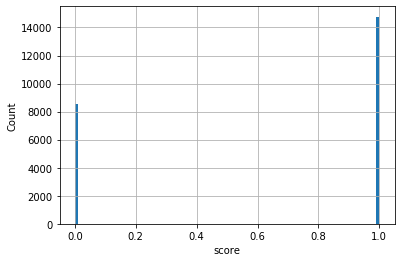

In [ ]:
X_fact_scored = X_fact.copy()
#X_fact_scored.score = X_fact_scored.score.apply(lambda x: np.log(x))

# plotting the distribution of conc inside this case
X_fact_scored.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

# Basic tests

In [ ]:
X = tc.SFrame(X_fact_scored)
X

test_cas,species,conc1_type,exposure_type,obs_duration_mean,score
0,378,F,F,48.0,1
0,378,F,F,96.0,1
1,217,F,AQUA,48.0,1
1,236,A,S,24.0,1
1,236,A,S,48.0,1
1,256,A,S,24.0,1
1,256,A,S,48.0,1
1,256,A,S,96.0,1
1,306,A,S,24.0,1
1,306,A,S,48.0,1


In [ ]:
X_cas = tc.SFrame(X_side_cas)
X_cas

test_cas,alone_atom_number,tripleBond,doubleBond,ring_numer
52,3,0,0,0.0
2424,2,0,1,1.0
642,5,0,5,2.0
1583,2,1,0,0.0
2020,0,0,0,2.0
1178,1,0,1,1.0
908,0,0,4,0.0
2192,5,0,2,0.0
2200,4,0,2,0.0
2412,0,0,0,1.0


In [ ]:
X_species = tc.SFrame(X_side_species)
X_species

species,class,tax_order,family,genus
39,Actinopterygii,Cypriniformes,Cyprinidae,Carassius
203,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Fundulus
306,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus
460,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Cyprinodon
320,Actinopterygii,Perciformes,Cichlidae,Oreochromis
220,Actinopterygii,Anguilliformes,Anguillidae,Anguilla
109,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus
92,Actinopterygii,Cypriniformes,Cyprinidae,Gibelion
168,Actinopterygii,Cypriniformes,Cyprinidae,Nothobranchius
2,Actinopterygii,Perciformes,Labridae,Tautogolabrus


In [ ]:
X_train_scored, X_test_scored = train_test_split(X_fact_scored, test_size=0.33, shuffle=True, random_state=13)
X_train, X_test = tc.SFrame(X_train_scored), tc.SFrame(X_test_scored)

In [ ]:
X_train

test_cas,species,conc1_type,exposure_type,obs_duration_mean,score
939,306,A,S,24.0,0
97,358,A,S,48.0,0
1523,256,F,AQUA,48.0,1
521,297,F,AQUA,48.0,0
379,256,A,S,24.0,1
415,256,A,S,24.0,1
1649,378,A,S,48.0,1
908,392,F,AQUA,24.0,0
1178,379,A,AQUA,96.0,0
820,236,F,S,48.0,0


In [ ]:
X_test

test_cas,species,conc1_type,exposure_type,obs_duration_mean,score
57,222,T,S,96.0,1
1256,447,F,S,24.0,1
1120,10,F,S,48.0,1
2521,364,F,S,48.0,1
939,460,A,S,96.0,0
931,53,A,R,96.0,0
735,256,F,S,24.0,1
589,367,T,AQUA,96.0,1
776,117,F,S,48.0,0
1222,383,F,S,96.0,0


In [ ]:
model = tc.recommender.factorization_recommender.create(X_train, 'test_cas', 'species', target='score', user_data=X_cas, solver="sgd", item_data=X_species, max_iterations=10000, binary_target=True)

Preparing data set.

Data has 15632 observations with 2621 users and 475 items.

Data prepared in: 0.061801s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 10000    |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15632 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.84615           | Not Viable                               |

| 1       | 0.961538          | Not Viable                               |

| 2       | 0.240385          | Not Viable                               |

| 3       | 0.0600962         | No Decrease (35.8555 >= 0.656595)        |

| 4       | 0.015024          | 0.49577                                  |

| 5       | 0.00751202        | 0.53044                                  |

| 6       | 0.00375601        | 0.552995                                 |

| 7       | 0.001878          | 0.571902                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.015024          | 0.49577                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 88us         | 0.658487          | 0.658487                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 45.144ms     | 0.530854          | 0.530854                          | 0.015024    |

| 2       | 73.412ms     | 0.50595           | 0.50595                           | 0.00893335  |

| 3       | 97.297ms     | 0.484918          | 0.484918                          | 0.00659092  |

| 4       | 122.183ms    | 0.519546          | 0.519546                          | 0.0053118   |

| 5       | 145.912ms    | 0.578964          | 0.578964                          | 0.00377835  |

| 10      | 269.696ms    | 0.754007          | 0.754007                          | 0.000188917 |

| 19      | 510.91ms     | DIVERGED          | DIVERGED                          | 7.33942e-06 |

| RESET   | 526.784ms    | 0.658454          | 0.658454                          |             |

| 31      | 1.28s        | 0.652217          | 0.652217                          | 2.79325e-07 |

| 81      | 2.53s        | 0.649837          | 0.649837                          | 1.35915e-07 |

| 231     | 6.13s        | 0.646717          | 0.646717                          | 6.19331e-08 |

| 481     | 12.14s       | 0.644461          | 0.644461                          | 3.57292e-08 |

| 731     | 18.11s       | 0.643097          | 0.643097                          | 2.61032e-08 |

| 981     | 24.07s       | 0.642047          | 0.642047                          | 2.09353e-08 |

| 1231    | 30.05s       | 0.640961          | 0.640961                          | 1.76579e-08 |

| 1353    | 32.95s       | 0.64034           | 0.64034                           | 1.64497e-08 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training Predictive Error.

Final objective value: 0.64034

Final training Predictive Error: 0.64034

In [ ]:
X_train_predict = model.predict(X_train)
X_train_predict

dtype: float
Rows: 15632
[0.622997575040689, 0.6476014906235918, 0.581247395075723, 0.6626832677694716, 0.6454880808224518, 0.6476621506363276, 0.6599519556606889, 0.6608503424843561, 0.6442266145438841, 0.6745082996146037, 0.6692642885937524, 0.6345430531811587, 0.606561109365841, 0.6457786864897148, 0.6686427156427693, 0.6684883232414839, 0.6365069932701287, 0.6223705948408765, 0.5896254861783496, 0.6500777658053388, 0.6747991732091125, 0.5539673951094262, 0.6804007941775895, 0.6832967298462996, 0.6640965805950679, 0.6700004838505909, 0.6302405833884991, 0.6794791200017436, 0.669842418536611, 0.6515422991600143, 0.6494983833515621, 0.6397510430368911, 0.6885214209046471, 0.6693302277055379, 0.6646547078129795, 0.584355501570471, 0.6009127875968759, 0.6846022723544339, 0.6795956749318574, 0.6593135127615308, 0.6622480357761956, 0.6016003189393953, 0.6607263619299792, 0.6770922240263069, 0.6666185006082385, 0.6450232887055418, 0.666852638954072, 0.6373968118741783, 0.6657362930516744, 

In [ ]:
X_train_predict = np.where(X_train_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_train.select_column('score').to_numpy(), X_train_predict)

0.6320368474923235

In [ ]:
X_test_predict = model.predict(X_test)
X_test_predict

dtype: float
Rows: 7700
[0.6695717956213498, 0.6492619231463219, 0.6641372357127668, 0.6688280166838767, 0.6253682271535524, 0.5781146919259906, 0.6278662902332693, 0.6721735800157895, 0.6246653147699173, 0.5799340133328149, 0.6802011563799427, 0.6669782132679366, 0.648078063690177, 0.6562363690918218, 0.6613426446463022, 0.627988421234042, 0.6082750186285626, 0.6501032300302851, 0.634831525839198, 0.6438845677155323, 0.6226215217639413, 0.6374907524796602, 0.6787420053107558, 0.6860603282600541, 0.6780848957947627, 0.6668718364794433, 0.6560172195626399, 0.6143365844469733, 0.6591773138639456, 0.6174028840213709, 0.6792537070068897, 0.6564423190407158, 0.6542046930716963, 0.6461596016099522, 0.6792026647330798, 0.652218603826207, 0.6577040894476807, 0.6570955826937862, 0.5851665990856348, 0.6480711271525362, 0.6214235686238587, 0.6867701234654577, 0.659187003302426, 0.6759056882311427, 0.5885454541193531, 0.673678525732155, 0.6111704827073262, 0.5992150571460293, 0.6529045909799126, 0

In [ ]:
X_test_score = X_test.select_column("score")
X_test_score

dtype: int
Rows: 7700
[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, ... ]

In [ ]:
X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_test_score.to_numpy(), X_test_predict)

0.6331168831168831

## Finding best set of features

In [ ]:
import itertools

best_rmse = np.inf
best_comb = []

X_train, X_test = tc.SFrame(X_train_scored), tc.SFrame(X_test_scored)

poss_side = np.array(["class", "tax_order", "family", "genus"] + ["alone_atom_number", "tripleBond", "doubleBond", "ring_numer"])
for k in range(0, 9):
  print("Starting k =",k)
  poss_comb = list(itertools.combinations(range(0,8),k))
  for c in poss_comb:
    side_cas = ["test_cas"]
    side_spec = ["species"]
    no_cas = False
    no_spec = False
    for i in list(c):
      if i in range(0, 4):
        side_spec.append(poss_side[i])
      else:
        side_cas.append(poss_side[i])
    if (len(side_cas)==1):
      no_cas = True
    if (len(side_spec)==1):
      no_spec = True
    
    X_side_species = base_db96.copy()
    X_side_species = X_side_species[side_spec]
    X_side_species = X_side_species.drop_duplicates(subset="species").reset_index(drop=True)

    X_side_cas = base_db96.copy()
    X_side_cas = X_side_cas[side_cas]
    X_side_cas = X_side_cas.drop_duplicates(subset="test_cas").reset_index(drop=True)
    X_side_cas = X_side_cas.dropna()

    X_side_species["species"] = enc_species.transform(X_side_species.species.values.reshape(-1,1))
    X_side_cas["test_cas"] = enc_cas.transform(X_side_cas.test_cas.values.reshape(-1,1))

    X_species = tc.SFrame(X_side_species)
    X_cas = tc.SFrame(X_side_cas)

    if (no_cas==True and no_spec==True):
      model = tc.recommender.factorization_recommender.create(X_train, user_id='test_cas', item_id='species', target='score', solver="sgd", max_iterations=1000, verbose=False, binary_target=True)
    elif(no_cas==True and no_spec==False):
      model = tc.recommender.factorization_recommender.create(X_train, user_id='test_cas', item_id='species', target='score', item_data=X_species, solver="sgd", max_iterations=1000, verbose=False, binary_target=True)
    elif(no_cas==False and no_spec==True):
      model = tc.recommender.factorization_recommender.create(X_train, user_id='test_cas', item_id='species', target='score', user_data=X_cas, solver="sgd", max_iterations=1000, verbose=False, binary_target=True)
    else:
      model = tc.recommender.factorization_recommender.create(X_train, user_id='test_cas', item_id='species', target='score', item_data=X_species, user_data=X_cas, solver="sgd", max_iterations=1000, verbose=False, binary_target=True)

    rmse = model.evaluate_rmse(X_test, 'score')['rmse_overall']

    if rmse<best_rmse:
      best_rmse = rmse
      best_comb = side_cas + side_spec
      print("Best combination found! RMSE: {}, features: {}".format(best_rmse, best_comb))
      

Starting k = 0
Best combination found! RMSE: 0.29450498744156034, features: ['test_cas', 'species']
Starting k = 1
Best combination found! RMSE: 0.28959237754888445, features: ['test_cas', 'species', 'class']
Starting k = 2
Best combination found! RMSE: 0.27363356779146514, features: ['test_cas', 'species', 'class', 'tax_order']
Best combination found! RMSE: 0.2677608604211085, features: ['test_cas', 'species', 'class', 'family']
Starting k = 3
Best combination found! RMSE: 0.2665269072888898, features: ['test_cas', 'species', 'class', 'family', 'genus']
Starting k = 4
Best combination found! RMSE: 0.266101375198106, features: ['test_cas', 'tripleBond', 'species', 'class', 'tax_order', 'genus']
Starting k = 5
Starting k = 6
Starting k = 7
Starting k = 8


In [ ]:
best_comb = ['test_cas', 'tripleBond', 'species', 'class', 'tax_order', 'genus']

In [ ]:
X_side_cas = base_db96.copy()
X_side_cas = X_side_cas[['test_cas', 'tripleBond']]
X_side_cas = X_side_cas.drop_duplicates(subset="test_cas").reset_index(drop=True)
X_side_cas = X_side_cas.dropna()
X_side_cas["test_cas"] = enc_cas.transform(X_side_cas.test_cas.values.reshape(-1,1))
X_cas = tc.SFrame(X_side_cas)

X_side_species = base_db96.copy()
X_side_species = X_side_species[['species', 'class', 'tax_order', 'genus']]
X_side_species = X_side_species.drop_duplicates(subset="species").reset_index(drop=True)
X_side_species["species"] = enc_species.transform(X_side_species.species.values.reshape(-1,1))
X_species = tc.SFrame(X_side_species)

In [ ]:
X_train, X_test = tc.SFrame(X_train_scored), tc.SFrame(X_test_scored)

model = tc.recommender.factorization_recommender.create(X_train, user_id='test_cas', item_id='species', target='score', user_data=X_cas, item_data=X_species, solver="sgd", max_iterations=1000, verbose=True, binary_target=True)

Preparing data set.

Data has 15632 observations with 2621 users and 475 items.

Data prepared in: 0.043926s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15632 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.55556           | Not Viable                               |

| 1       | 1.38889           | Not Viable                               |

| 2       | 0.347222          | Not Viable                               |

| 3       | 0.0868056         | 0.265352                                 |

| 4       | 0.0434028         | No Decrease (0.693612 >= 0.656608)       |

| 5       | 0.0108507         | 0.533255                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0868056         | 0.265352                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 49us         | 0.658496          | 0.658496                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 36.256ms     | 0.515419          | 0.515416                          | 0.0868056   |

| 2       | 59.321ms     | 0.396741          | 0.396738                          | 0.0516149   |

| 3       | 83.896ms     | 0.336349          | 0.336346                          | 0.0380808   |

| 4       | 114.777ms    | 0.294111          | 0.294107                          | 0.0306904   |

| 5       | 143.494ms    | 0.268667          | 0.268663                          | 0.0259609   |

| 10      | 250.499ms    | 0.191806          | 0.191799                          | 0.0154365   |

| 50      | 1.05s        | 0.0847037         | 0.0846887                         | 0.00461658  |

| 100     | 2.05s        | 0.0626766         | 0.0626597                         | 0.000171565 |

| 132     | 2.71s        | 0.06198           | 0.0619631                         | 1.23138e-05 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training Predictive Error.

Final objective value: 0.0619435

Final training Predictive Error: 0.0619266

In [ ]:
model.evaluate_rmse(X_train, 'score')['rmse_overall']

0.12697740184482492

In [ ]:
X_train_predict = model.predict(X_train)
X_train_score = X_train.select_column("score")
X_train_predict = np.where(X_train_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_train_score.to_numpy(), X_train_predict)

0.9815762538382804

In [ ]:
model.evaluate_rmse(X_test, 'score')['rmse_overall']

0.27091323172704734

In [ ]:
X_test_predict = model.predict(X_test)
X_test_score = X_test.select_column("score")
X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_test_score.to_numpy(), X_test_predict)

0.9115584415584416

# Implementing CV

In [ ]:
X_train_original, X_test_original, X_train_scored, X_test_scored = train_test_split(X_original, X_fact_scored, test_size=0.33)

In [ ]:
X_train_original = X_train_original.reset_index(drop=True)
X_test_original = X_test_original.reset_index(drop=True)
X_train_scored = X_train_scored.reset_index(drop=True)
X_test_scored = X_test_scored.reset_index(drop=True)

In [ ]:
factors = list(range(1, 15, 1))
regularizs = np.logspace(-12, 1, 20)
lin_regularizs = np.logspace(-12, 1, 20)
best_acc, best_lin_regulariz, best_regulariz, best_factor = cv_fact_class(X_train_scored, X_cas, X_species, factors, regularizs, lin_regularizs, cv = 3, verbose=True, params_samples = False)
# pickle.dump(best_acc, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_acc_class_cat.pkl", "wb" ) )
# pickle.dump(best_lin_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_lin_reg_class_cat.pkl", "wb" ) )
# pickle.dump(best_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_regulariz_class_cat.pkl", "wb" ) )
# pickle.dump(best_factor, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_factor_class_cat.pkl", "wb" ) )

New best param combination found! RMSE:0.36682714300000246, Acc:0.7975935668346636, num_factors:1, regularizer:1e-12, lin_reg:1e-12
New best param combination found! RMSE:0.3586232514368021, Acc:0.7984263934025088, num_factors:1, regularizer:1e-12, lin_reg:5.455594781168515e-10
New best param combination found! RMSE:0.34123674999231596, Acc:0.8220288839753201, num_factors:1, regularizer:1e-12, lin_reg:1.2742749857031347e-08
New best param combination found! RMSE:0.3084791836529726, Acc:0.8552984710599766, num_factors:1, regularizer:4.832930238571752e-12, lin_reg:2.976351441631319e-07
New best param combination found! RMSE:0.30296793993458027, Acc:0.8553578341401679, num_factors:1, regularizer:2.976351441631319e-07, lin_reg:6.158482110660267e-08
New best param combination found! RMSE:0.2791507907036466, Acc:0.8721852967902315, num_factors:2, regularizer:1e-12, lin_reg:1e-12
New best param combination found! RMSE:0.27257437366302617, Acc:0.8799896571957078, num_factors:2, regularizer:1e-

In [ ]:
factors = list(range(7, 15, 1))
regularizs = np.logspace(-12, -1, 30)
lin_regularizs = np.logspace(-12, -1, 30)
best_acc, best_lin_regulariz, best_regulariz, best_factor = cv_fact_class(X_train_scored, X_cas, X_species, factors, regularizs, lin_regularizs, cv = 3, verbose=True, params_samples = False)
# pickle.dump(best_acc, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_acc_class_cat.pkl", "wb" ) )
# pickle.dump(best_lin_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_lin_reg_class_cat.pkl", "wb" ) )
# pickle.dump(best_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_regulariz_class_cat.pkl", "wb" ) )
# pickle.dump(best_factor, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_factor_class_cat.pkl", "wb" ) )

New best param combination found! RMSE:0.3019561857087426, Acc:0.88318746713391, num_factors:7, regularizer:1e-12, lin_reg:1e-12
New best param combination found! RMSE:0.29788795292614484, Acc:0.8797331620337067, num_factors:7, regularizer:1e-12, lin_reg:2.395026619987481e-12
New best param combination found! RMSE:0.29498621854786805, Acc:0.8843398966677237, num_factors:7, regularizer:1e-12, lin_reg:7.880462815669904e-11
New best param combination found! RMSE:0.2933349858879905, Acc:0.8894568959579452, num_factors:7, regularizer:1e-12, lin_reg:4.5203536563602404e-10
New best param combination found! RMSE:0.29213007934474744, Acc:0.8865793765415524, num_factors:7, regularizer:1e-12, lin_reg:1.610262027560939e-05
New best param combination found! RMSE:0.2902314739294729, Acc:0.8884983203379141, num_factors:7, regularizer:5.736152510448681e-12, lin_reg:6.210169418915603e-09
New best param combination found! RMSE:0.28997464077599405, Acc:0.8870264720048747, num_factors:7, regularizer:1.887

In [ ]:
factors = list(range(1, 51, 5))
regularizs = np.logspace(-12, 0, 20)
lin_regularizs = np.logspace(-12, 0, 20)
best_acc, best_lin_regulariz, best_regulariz, best_factor = cv_fact_class(X_train_scored, X_cas, X_species, factors, regularizs, lin_regularizs, cv = 3, verbose=True, params_samples = False)
# pickle.dump(best_acc, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_acc_class_cat.pkl", "wb" ) )
# pickle.dump(best_lin_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_lin_reg_class_cat.pkl", "wb" ) )
# pickle.dump(best_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_regulariz_class_cat.pkl", "wb" ) )
# pickle.dump(best_factor, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_factor_class_cat.pkl", "wb" ) )

New best param combination found! Acc:0.79752919441906, num_factors:1, regularizer:1e-12, lin_reg:1e-12
New best param combination found! Acc:0.8079580045803497, num_factors:1, regularizer:1e-12, lin_reg:3.3598182862837877e-10
New best param combination found! Acc:0.8123097910530076, num_factors:1, regularizer:1e-12, lin_reg:8.858667904100815e-06
New best param combination found! Acc:0.8134591265855375, num_factors:1, regularizer:3.3598182862837877e-10, lin_reg:1e-12
New best param combination found! Acc:0.8135233639455294, num_factors:1, regularizer:1.4384498882876659e-09, lin_reg:3.792690190732246e-05
New best param combination found! Acc:0.8142906025972666, num_factors:1, regularizer:0.002976351441631313, lin_reg:1e-12
New best param combination found! Acc:0.8200486494868562, num_factors:1, regularizer:0.002976351441631313, lin_reg:4.281332398719396e-12
New best param combination found! Acc:0.8274695870109897, num_factors:1, regularizer:0.002976351441631313, lin_reg:1.83298071083243

In [ ]:
def cv_fact_class(X_scored, X_cas, X_species, factors, regularizs, lin_regulars,  cv = 3, verbose=True, params_samples = True, num_samples = 5):
  best_factor = 0
  best_regulariz = 0
  best_lin_regulariz = 0
  best_acc = 0
  best_rmse = np.inf
  np.random.seed(13)

  if params_samples:
    factors = np.random.choice(factors, num_samples)
    regularizs = np.random.choice(regularizs, num_samples)
    lin_regulars = np.random.choice(lin_regulars, num_samples)
    
  for factor in factors:
    for regulariz in regularizs:
      for lin_regular in lin_regulars:
        accs = []
        rmses = []
        kf2 = KFold(n_splits=cv, shuffle=True)

        for train_ind, test_ind in kf2.split(X_scored):
          train = tc.SFrame(X_scored.loc[train_ind])
          test = tc.SFrame(X_scored.loc[test_ind])

          model = tc.recommender.factorization_recommender.create(train, 'test_cas', 'species', target='score', max_iterations=1000, \
                                                                  num_factors = factor, regularization=regulariz, linear_regularization=lin_regular, solver="sgd", verbose=False, binary_target=True, user_data=X_cas, item_data=X_species)
          
          X_test_predict = model.predict(test)
          X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
          acc = accuracy_score(X_scored.loc[test_ind].score.values, X_test_predict)
          rmse = model.evaluate_rmse(X_test, 'score')['rmse_overall']
          accs.append(acc)
          rmses.append(rmse)
        
        acc_avg = np.mean(accs)
        rmse_avg = np.mean(rmses)

        if (rmse_avg < best_rmse):
          if verbose:
            print("New best param combination found! RMSE:{}, Acc:{}, num_factors:{}, regularizer:{}, lin_reg:{}".format(rmse_avg, acc_avg, factor, regulariz, lin_regular))     
          best_acc = acc_avg
          best_rmse = rmse_avg
          best_lin_regulariz = lin_regular
          best_regulariz = regulariz
          best_factor = factor
    
  return best_acc, best_lin_regulariz, best_regulariz, best_factor


In [ ]:
best_factor = 7
best_regulariz = 0.012742749857031322
best_lin_regulariz = 1.1288378916846883e-07

In [ ]:
X_train, X_test = tc.SFrame(X_train_scored), tc.SFrame(X_test_scored)

model = tc.recommender.factorization_recommender.create(X_train, user_id='test_cas', item_id='species', target='score', user_data=X_cas, item_data=X_species, solver="sgd", max_iterations=1000, verbose=True, binary_target=True,\
                                                        num_factors=best_factor, regularization=best_regulariz, linear_regularization=best_lin_regulariz)

Preparing data set.

Data has 15632 observations with 2621 users and 475 items.

Data prepared in: 0.048027s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 7        |

| regularization                 | L2 Regularization on Factors                     |          |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1.13e-07 |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 15632 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.369033          | Not Viable                               |

| 1       | 0.0922582         | 0.453288                                 |

| 2       | 0.0461291         | 0.539472                                 |

| 3       | 0.0230645         | 0.525701                                 |

| 4       | 0.0115323         | 0.552894                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0922582         | 0.453288                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 222us        | 0.658497          | 0.658496                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 44.618ms     | 0.681753          | 0.52685                           | 0.0922582   |

| 2       | 77.36ms      | 0.500099          | 0.44595                           | 0.00476114  |

| 3       | 111.466ms    | 0.463033          | 0.422424                          | 0.00244362  |

| 4       | 145.472ms    | 0.459377          | 0.418793                          | 0.00163807  |

| 5       | 178.136ms    | 0.451355          | 0.416804                          | 0.00123507  |

| 10      | 330.595ms    | 0.444755          | 0.411136                          | 0.000551137 |

| 50      | 1.59s        | 0.432081          | 0.404313                          | 2.1556e-05  |

| 100     | 3.11s        | 0.431316          | 0.40388                           | 3.20431e-06 |

| 110     | 3.42s        | 0.431277          | 0.403858                          | 2.50861e-06 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training Predictive Error.

Final objective value: 0.43128

Final training Predictive Error: 0.40386

In [ ]:
model_test.evaluate_rmse(tc.SFrame(X_test_sc), 'score')['rmse_overall']

0.3595002492594436

In [ ]:
X_test_predict = model_test.predict(tc.SFrame(X_test_sc))
X_test_predict

dtype: float
Rows: 7700
[0.8592305008191438, 0.632156900440124, 0.8754358222268596, 0.9006166887525895, 0.431353634693737, 0.731679445888778, 0.7155138513645887, 0.808632734213072, 0.3312239636636498, 0.10251256296777748, 0.7399940872097318, 0.8581706689768952, 0.6602484228365514, 0.8872814366029363, 0.8361542535762623, 0.8132042295524919, 0.12331214145069266, 0.45367682067508575, 0.8089710912549444, 0.7949842215699139, 0.9666676618567526, 0.6849566928897497, 0.6011764259636545, 0.9462810469128009, 0.9072577124061832, 0.9441227633168894, 0.49812614300471947, 0.6125689668870193, 0.8440412112791789, 0.542017079472772, 0.6586392490468915, 0.5651847642642228, 0.76191538708631, 0.4427139120787785, 0.7214996307106853, 0.1591587251933669, 0.7901314126847088, 0.8122407452001399, 0.16033534214993425, 0.8393482388032704, 0.19195097311868192, 0.9259481778436081, 0.8771863073560706, 0.8914568994146459, 0.08422851105425636, 0.7631207449926822, 0.5975129213199716, 0.8983033869309663, 0.6899531997417

In [ ]:
X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_test_sc.score, X_test_predict)

0.8318181818181818